In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline

import math
import re
import scrapy
import requests
import datetime

from textblob import TextBlob

import networkx as nx

from datetime import datetime, timedelta

In [4]:
def clean_script(raw_script):
    if isinstance(raw_script,str):
        striped_script = ' '.join(raw_script.split())
        clean_script = re.sub(r'\d+:\d+', '', striped_script)
        #clean_script = re.sub(r'\(.*?\)', '', clean_script)
        clean_script = clean_script.strip()
    else:
        clean_script = ""
    return clean_script

def remove_bracket_script(raw_script):
    if isinstance(raw_script,str):
        striped_script = ' '.join(raw_script.split())
        clean_script = re.sub(r'\(.*?\)', '', striped_script)
        clean_script = clean_script.strip()
    else:
        clean_script = ""
    return clean_script

In [14]:
def find_first_occur_position(text, target, relative = True):
    target_first_occur = text.lower().find(target)
    if target_first_occur + 1: # if target not found in this text, -1+1 = 0 = False
        text_char_length = len(text)
        if relative:
            first_occur_pos = target_first_occur/text_char_length
        else: # return absolute index
            first_occur_pos = target_first_occur
        return first_occur_pos
    return np.nan

def locate_first_occur(word, df = ted):
    colname = word+'_first_occur_pos'
    ted[colname] = ted['transcript'].apply(lambda script: find_first_occur_position(script,word))
    ted[colname].hist(bins=40)
    

def find_all_occur_position(text, target, relative = True):
    pos_list = [m.start() for m in re.finditer(target, text)]
    pos_list = np.asarray(pos_list)
    if len(pos_list)!= 0:
        if relative:
            pos_list = pos_list/len(text)
    return pos_list

def locate_all_occur(word, df = ted):
    colname = word+'_all_occur_pos'
    ted[colname] = ted['transcript'].apply(lambda script: find_all_occur_position(script,word))
    total_pos_list = []
    for pos_list in ted[colname]:
        total_pos_list += list(pos_list)
    total_pos_list = np.asarray(total_pos_list)
    plt.hist(total_pos_list,bins=40)

In [21]:
def pola_subj_sequence(script, level):
    script = TextBlob(script)
    
    sd_p,sd_pola,sd_subj = [],[],[]

    if level == "words":
        ls = script.words
    elif level == "noun_phrases":
        ls = script.noun_phrases
    elif level == "sentences":
        ls = [str(s) for s in script.sentences]
        
    for p in ls:
        p_ = TextBlob(p)
        sd_p.append(p)
        sd_pola.append(p_.sentiment[0])
        sd_subj.append(p_.sentiment[1])

    return np.asarray(sd_p),np.asarray(sd_pola),np.asarray(sd_subj)

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def three_graph(indices):
    plt.figure(figsize=(10, 6))

    # TOP 1
    plt.subplot(231)
    script = ted['transcript'][indices[0]]     # control which talk
    axes = plt.gca()
    axes.set_ylim([-1,1])
    plt.plot(pola_subj_sequence(script,'sentences')[1])

    # DOWN 1
    plt.subplot(234)
    sentences_pola = pola_subj_sequence(script,'sentences')[1]
    axes = plt.gca()
    #axes.set_xlim([xmin,xmax])
    axes.set_ylim([-0.4,0.4])
    plt.plot(running_mean(sentences_pola, 5),c = 'orange')
    plt.plot(running_mean(sentences_pola, 10),c = 'green')
    plt.plot(running_mean(sentences_pola, 20),c = 'blue')


    # TOP 2
    plt.subplot(232)
    script = ted['transcript'][indices[1]]     # control which talk
    axes = plt.gca()
    axes.set_ylim([-1,1])
    plt.plot(pola_subj_sequence(script,'sentences')[1])

    # DOWN 2
    plt.subplot(235)
    sentences_pola = pola_subj_sequence(script,'sentences')[1]
    axes = plt.gca()
    #axes.set_xlim([xmin,xmax])
    axes.set_ylim([-0.4,0.4])
    plt.plot(running_mean(sentences_pola, 5),c = 'orange')
    plt.plot(running_mean(sentences_pola, 10),c = 'green')
    plt.plot(running_mean(sentences_pola, 20),c = 'blue')

    # TOP 3
    plt.subplot(233)
    script = ted['transcript'][indices[2]]     # control which talk
    axes = plt.gca()
    axes.set_ylim([-1,1])
    plt.plot(pola_subj_sequence(script,'sentences')[1])

    # DOWN 3
    plt.subplot(236)
    sentences_pola = pola_subj_sequence(script,'sentences')[1]
    axes = plt.gca()
    #axes.set_xlim([xmin,xmax])
    axes.set_ylim([-0.4,0.4])
    plt.plot(running_mean(sentences_pola, 5),c = 'orange')
    plt.plot(running_mean(sentences_pola, 10),c = 'green')
    plt.plot(running_mean(sentences_pola, 20),c = 'blue')

## Start here

In [6]:
ted = pd.read_csv('ted_with_script.csv')

#### The first occurence of keyword "story" usually takes place at the beginning of a speech

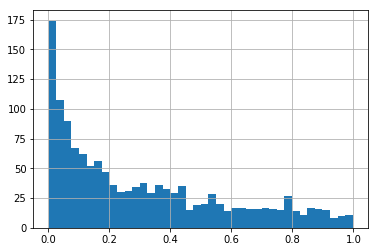

In [18]:
locate_first_occur('story')

#### Keyword "but" occurs more frequently at the end of a speech

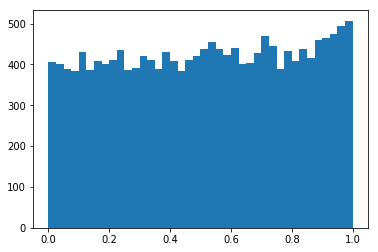

In [19]:
locate_all_occur('but')

#### Phenomenon: 
Keyword "if" occurs more frequently at the end of a speech.
#### Potential Explanation: 
Speakers making call-for-action at the end. "If everyone do this, then ..."

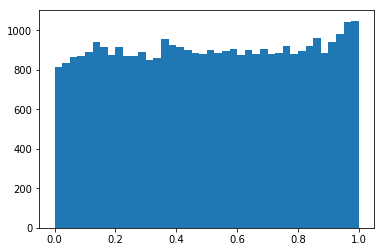

In [20]:
locate_all_occur('if')

## Pos/Neg Emotion Extremes

In [24]:
ted_emotion = pd.read_csv('TED_Talks_by_ID_plus-transcripts-and-LIWC-and-MFT-plus-views.csv')[['headline']+['affect', 'posemo', 'negemo', 'anx', 'anger', 'sad']]
ted = pd.merge(ted,ted_emotion,on='headline')
ted['pos-neg'] = ted['posemo'] - ted['negemo']

### Most Positive
index: 853, 329, 880

In [70]:
ted.sort_values(by = 'pos-neg',ascending = False)[['headline','posemo','negemo','pos-neg','transcript']].head(3)
# ted.sort_values(by = 'posemo',ascending = False)[['headline','posemo','negemo','pos-neg','transcript']].head()

,headline,posemo,negemo,pos-neg,transcript
853,Everyday compassion at Google,8.52,0.22,8.30,So what does the happiest man in the world loo...
329,Do the green thing,9.23,1.29,7.94,"Great creativity. In times of need, we need gr..."
880,The hidden power of smiling,7.83,0.92,6.91,"When I was a child, I always wanted to be a su..."


### Most Negative
index: 981, 1448, 1009

In [68]:
ted.sort_values(by = 'pos-neg',ascending = True)[['headline','posemo','negemo','pos-neg','transcript']].head(3)
# ted.sort_values(by = 'negemo',ascending = False)[['headline','posemo','negemo','pos-neg','transcript']].head()

,headline,posemo,negemo,pos-neg,transcript
981,How cyberattacks threaten real-world peace,1.75,6.53,-4.78,Good afternoon. If you have followed diplomati...
1448,For argument's sake,4.26,8.40,-4.14,"My name is Dan Cohen and I am an academic, as ..."
1009,Philosophy in prison,1.28,4.82,-3.54,"Meet Tony. He's my student. He's about my age,..."


### 3 Talks with most Positive emotion


               Emotion Trajectory of most positive talks


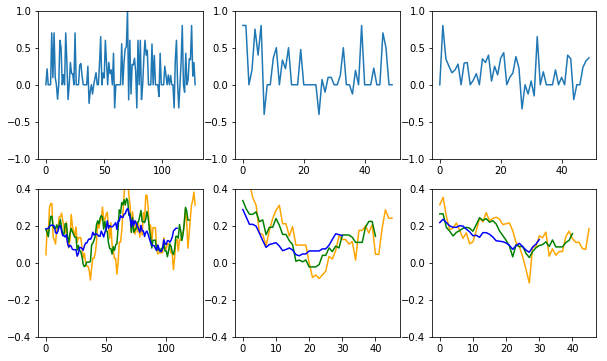

In [58]:
indices = [853, 329, 880]
# ted.iloc[indices,:]['transcript']

print('\n               Emotion Trajectory of most positive talks')
three_graph(indices)

### 3 Talks with most Negative emotion


              Emotion Trajectory of most negative talks


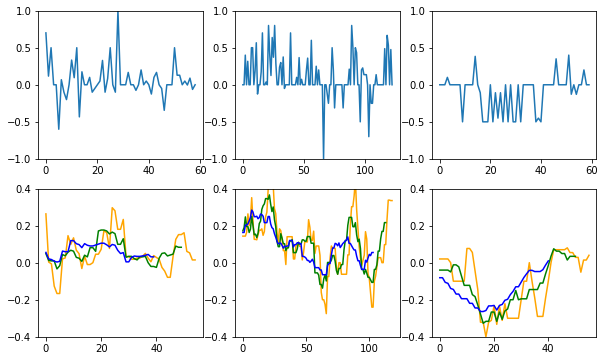

In [57]:
indices = [981, 1448, 1009]
# ted.iloc[indices,:]['transcript']
print('\n              Emotion Trajectory of most negative talks')
three_graph(indices)

<br><br><br>
## Most Viewed v.s. Least Viewed

In [71]:
most_viewed_data = ted.sort_values(by = 'views',ascending = False)[['headline','views','film_date','published_date','posemo','negemo','pos-neg','transcript']].head()
most_viewed_indices = most_viewed_data.index
#most_viewed_data

In [72]:
least_viewed_data = ted.sort_values(by = 'views',ascending = True)[['headline','views','film_date','published_date','posemo','negemo','pos-neg','transcript']].head()
least_viewed_indices = least_viewed_data.index
#least_viewed_data

### Does Most Viewed Talks has more changes in emotion states than Least Viewed Talks?


                 Emotion Trajectory of most viewed talks


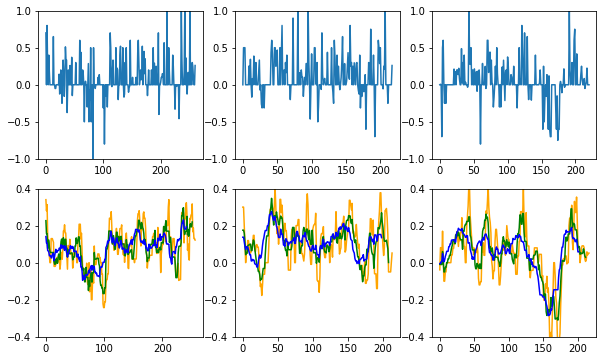

In [76]:
print('\n                Emotion Trajectory of most viewed talks')
three_graph(most_viewed_indices)


                Emotion Trajectory of least viewed talks


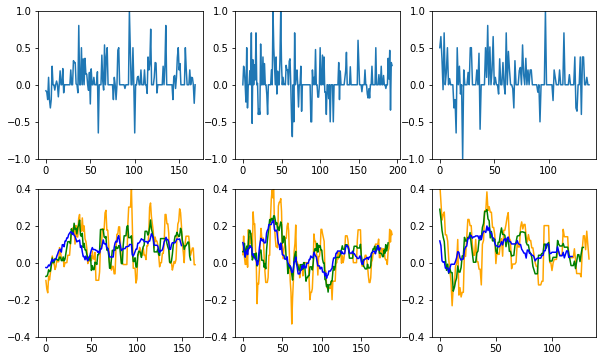

In [78]:
print('\n                Emotion Trajectory of least viewed talks')
three_graph(least_viewed_indices)

## Inspired by Sparkline: can we use tense of verb as proxy for current v.s. future?

In [41]:
import operator
def maxDict(dictionary):
    return max(dictionary.items(), key=operator.itemgetter(1))[0]

In [42]:
# https://stackoverflow.com/questions/30016904/determining-tense-of-a-sentence-python/45128430
from nltk import word_tokenize, pos_tag

def determine_tense(sentence, return_number = False):
    text = word_tokenize(sentence)
    tagged = pos_tag(text)

    tense = {}
    tense["future"] = len([word for word in tagged if word[1] in ["MD"]])
    tense["present"] = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    tense["past"] = len([word for word in tagged if word[1] in ["VBD", "VBN"]]) 
    
    output = maxDict(tense)
    
    if return_number:
        if output == 'past':
            output = -1
        elif output == 'present':
            output = 0
        else:
            output = 1
    
    return output

In [73]:
def tenseGraph(index):
    script = TextBlob(ted.transcript[i])
    sentences = [str(s) for s in script.sentences]

    tense_seq = np.asarray([determine_tense(s,True) for s in sentences])
    #plt.plot(tense_seq)

    axes = plt.gca()
    axes.set_xlim([0,250])
    axes.set_ylim([-1.1,1.1])
    
    #axes.set_title(str(index),ted.headline[index])

    #markers_on = [int(pos) for pos in find_all_occur_position(ted.transcript[i],'if')*len(sentences)]
    plt.plot(running_mean(tense_seq, 5),c = 'orange')
    #plt.plot(running_mean(tense_seq, 10),c = 'red')
    plt.plot(running_mean(tense_seq, 20),c = 'blue')


### Drawing tense trajectory of first 100 talks at the interval of 0.3 seconds for manual inspection

In [ ]:
%matplotlib notebook

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

for i in range(0,100):
    ax.clear()
    
    tenseGraph(i)
    fig.canvas.draw()
    time.sleep(0.3)

%matplotlib inline

It seems two valleys or more are common in a medium to long ted talks, indicating that people might give examples or share past experiences in those parts. Moreover, the end is typically tipping upwards, suggesting the end has more call-to-action and thoughts on the future.

<br><br><br><br><br><br>
### Now let's explore the related talks network

In [75]:
txt = ted.related_talks[0]
import ast
ast.literal_eval(txt)[:1]

[{'id': 865,
  'hero': 'https://pe.tedcdn.com/images/ted/172559_800x600.jpg',
  'speaker': 'Ken Robinson',
  'title': 'Bring on the learning revolution!',
  'duration': 1008,
  'slug': 'sir_ken_robinson_bring_on_the_revolution',
  'viewed_count': 7266103}]

In [ ]:
class Talk:

    def __init__(self,index,headline):
        self.index = index
        self.headline = headline
        self.hero = ''
        self.speaker = ''
        self.duration = 0
        self.slug = ''
        self.viewed_count = 0
        self.pointed_from = []
        self.pointing_to = []
        
  
    def change_headline(self, new_headline):
        self.headline = new_headline
        
    def change_dict_parameters(self, dic):
        if dic['title'] != self.headline:
            print(f"Headline mismatch, trying to copy info of {dic['title']} into object {self.headline}")
        else:
            self.hero = dic['hero']
            self.speaker = dic['speaker']
            self.duration = dic['duration']
            self.slug = dic['slug']
            self.viewed_count = dic['viewed_count']

    def add_pointed_from(self, new_pointed_from):
        self.pointed_from.append(new_pointed_from)
        
    def add_pointing_to(self, new_pointing_to):
        self.pointing_to.append(new_pointing_to)
        

talk1 = Talk(0,'Do schools kill creativity?')
print(talk1.duration)

In [ ]:
# pre double quote replacement
print([h for h in list(ted.headline) if '"' in h])

In [ ]:
# double quote replacement
ted.headline = ted.headline.apply(lambda x: x.replace('"','/'))

In [ ]:
# post double quote replacement
[h for h in list(ted.headline) if '"' in h]

In [ ]:
# create Talk object for every talk in the ted dataframe
for i in range(len(ted)):
    exec(f'talk_{i} = Talk({i},"'+ted.headline[i]+'")')

In [ ]:
talks_not_found = []
for i in range(len(ted)):
    this_talk_object = eval(f'talk_{i}')
    related_talks_dicts = ast.literal_eval(ted.related_talks[i])
    for related_talk_dict in related_talks_dicts:
        try:
            headline_of_dict = related_talk_dict['title']
            object_index = ted[ted['headline'] == headline_of_dict].index[0]
            other_talk_object = eval(f'talk_{object_index}')
            other_talk_object.change_dict_parameters(related_talk_dict)
            other_talk_object.add_pointed_from(this_talk_object)
            this_talk_object.add_pointing_to(other_talk_object)
        except:
            #print(f'The talk titled {headline_of_dict} is not found in ted dataframe.')
            talks_not_found.append(headline_of_dict)
                

In [ ]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

intersection(talks_not_found,list(ted.headline))

In [ ]:
# vars(talk_0)

In [ ]:
object_edge_list = []
for i in range(len(ted)):
    this_object = eval(f'talk_{i}')
    for other_object in this_object.pointing_to:
        object_edge_list.append((this_object,other_object))

print("Number of edges:", len(object_edge_list))
print(object_edge_list[:2])

In [ ]:
G = nx.DiGraph()

In [ ]:
G.add_edges_from(object_edge_list)

In [ ]:
numbers = range(len(G.nodes))

In [ ]:
object_names = [f'talk_{number}' for number in numbers]

In [ ]:
objects = [eval(obj_name) for obj_name in object_names]

In [ ]:
# object_var to talk_i
mapping = dict(zip(objects, object_names))

In [ ]:
talk_headlines = [talk.headline for talk in objects]

In [ ]:
# talk_i to headline
mapping2 = dict(zip(object_names, talk_headlines))

In [ ]:
heros = [talk.hero for talk in objects]

In [ ]:
# talk_i to headline
mapping3 = dict(zip(talk_headlines, heros))

In [ ]:
H = nx.relabel_nodes(G, mapping)

In [ ]:
# pos = nx.spring_layout(H)
# nx.draw_networkx_edges(H, pos, node_size = 10)

In [ ]:
viewed_counts_list = [talk.viewed_count for talk in objects]
plt.plot(np.asarray(sorted(viewed_counts_list)))

In [ ]:
thres_for_top= np.percentile(sorted(viewed_counts_list),80)
print(thres_for_top)

In [ ]:
bottom_talks = [talk for talk in objects if talk.viewed_count < thres_for_top]

In [ ]:
H = nx.relabel_nodes(G, mapping)
for talk in bottom_talks:
    H.remove_node(mapping[talk])

In [ ]:
# pos = nx.spring_layout(H)
# nx.draw_networkx_edges(H, pos, node_size = 500)

In [ ]:
P = nx.relabel_nodes(H, mapping2)

In [ ]:
days_list = list(ted['days_till_end'])
OldMax = days_list[0]
OldMin = days_list[-1]
NewMax = 255 # max blue, red will be (255-blue)
NewMin = 0

hex_code_list = []

for OldValue in days_list:
    NewValue = int((((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin)
    rgb_tuple = (255-NewValue,0,NewValue)
    hex_code = '#%02x%02x%02x' % rgb_tuple
    hex_code_list.append(hex_code)
    
ted['hex_code_r_new_b_old'] = hex_code_list

In [ ]:
#from pyvis.network import Network
from pyvis import network as net

ted_net = net.Network(height="750px", width="100%", bgcolor="#ffffff", font_color="black",notebook = True)
ted_net.from_nx(P)

# set the physics layout of the network
ted_net.barnes_hut()

neighbor_map = ted_net.get_adj_list()

# add neighbor data to node hover data
for node in ted_net.nodes:
    hero = mapping3[node["id"]]
    node["title"] = node["id"]+"<br>Related talks:<br>" + "<br>".join(neighbor_map[node["id"]]) #f'<img src="{hero}" height="40" width="40">'
    node["value"] = int(ted[ted['headline'] == node["id"]]['views'])
    node["color"] = str(ted[ted['headline'] == node["id"]][['hex_code_r_new_b_old']]).split()[-1]
    node['labelHighlightBold'] = True
    # node["mass"] = node["value"]



ted_net.show("ted.html")

In [ ]:
# import statsmodels.api as sm
# def linreg_summary(y,x,df,log = False,intercept = True):

#     x_list = x if isinstance(x, list) else [x]
#     print('linreg', y, "~", x_list)    

#     df['intercept'] = 1
#     intercept_list = ['intercept'] if intercept else []
    
#     if type(log) != list:   # True / False
#         if log:
#             lm=sm.OLS(np.log(df[y]+1),np.log(df[intercept_list + x_list]+1))
#         else:
#             lm=sm.OLS(df[y],df[intercept_list + x_list])
#     else:   # log = [True, False]    log(y) ~ x
#         if len(log) != 2:
#             print("Error, not defined.")
#         else:
#             if log[0]:
#                 y = np.log(df[y]+1)
#             if log[1]:
#                 x = np.log(df[intercept_list + x_list]+1)
#             lm=sm.OLS(y,x)
    
#     slr_results = lm.fit()
    
#     df.drop('intercept',axis = 1,inplace = True)
    
#     return slr_results.summary()



## Appendix

### Does the publish time matter for the most viewed selection?

In [ ]:
ted['year'] = ted['published_date'].apply(lambda string: int(string.split('/')[0]))

In [ ]:
ted['year'].hist()

In [ ]:
sns.regplot(x="year", y="views", data=ted)

In [ ]:
first_published_date = datetime.strptime(ted['published_date'].sort_values()[0], '%Y/%m/%d')
first_published_date

In [ ]:
last_published_date = datetime.strptime(ted['published_date'].sort_values()[len(ted['published_date'].sort_values())-1], '%Y/%m/%d')
last_count_date = datetime.strptime('2017/12/31', '%Y/%m/%d')
last_count_date

In [ ]:
ted['days_since_start'] = ted['published_date'].apply(lambda x: (datetime.strptime(x, '%Y/%m/%d')-first_published_date).days)

In [ ]:
ted['days_till_end'] = ted['published_date'].apply(lambda x: (last_count_date - datetime.strptime(x, '%Y/%m/%d')).days)

In [ ]:
ted['views_per_day'] = ted['views']/ted['days_till_end']

In [ ]:
sns.regplot(x="days_till_end", y="views_per_day", data=ted)

Seems to suggest more recent talks get more views per day since their published, but the methods might be fundamentally flawed. See the example below: with equal views for all, the division operation implies the final shape of the product is a downward sloping curve.

In [ ]:
test_views = np.ones(4000)*10000
test_days = np.arange(500,4500)
plt.plot(np.divide(test_views,test_days))